In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [8]:
merged_df = pd.read_csv('body_type_merged_data.csv')
merged_df.head(2)

,bust,hips,waist,height,gender
0,8,8,7,24,female
1,8,19,14,63,female


Let's work on the building blocks defining key differences and ratios

In [5]:
# We define a tiny number to prevent division by zero in ratios, making calculations safer.
safety_epsilon = 1e-6 # A very small number like 0.000001

##### *Calculate the main ratios that define body shapes*

Waist-to-Hip Ratio (WHR)

In [9]:
# WHR: How much narrower the waist is compared to the hips.
# Lower WHR generally means a more defined waist.
merged_df['whr'] = merged_df['waist'] / (merged_df['hips'] + safety_epsilon)

Bust-to-Hip Ratio (BHR)

In [10]:
# BHR: How the bust size compares to the hip size.
# BHR near 1 means bust and hips are similar.
merged_df['bhr'] = merged_df['bust'] / (merged_df['hips'] + safety_epsilon)

In [11]:
print("\nDataFrame after calculating WHR, BHR:")
print(merged_df[['bust', 'hips', 'waist', 'height', 'whr', 'bhr']].head())


DataFrame after calculating WHR, BHR:
   bust  hips  waist  height       whr       bhr
0     8     8      7      24  0.875000  1.000000
1     8    19     14      63  0.736842  0.421053
2     9    20     17      49  0.850000  0.450000
3     9    45     41      60  0.911111  0.200000
4    10    11      9      46  0.818182  0.909091


##### *Body Type Classification Rules (Thresholds)*
- These are the specific numerical boundaries (in inches) that define each body type

In [12]:
# General Thresholds
diff_bust_hips_small = 1.0       # (bust - hips) <= 1 inch
diff_hips_bust_small = 3.6       # (hips - bust) < 3.6 inches
diff_waist_defined = 9.0         # (bust - waist) >= 9 inches (for defined waist)
diff_hips_waist_defined = 10.0   # (hips - waist) >= 10 inches (for defined waist)

In [13]:
# Specific Thresholds for Each Body Type
diff_hips_bust_medium_bottom_hour = 10.0     # (hips - bust) < 10 inches (for Bottom Hourglass)

diff_bust_hips_medium_top_hour = 10.0     # (bust - hips) < 10 inches (for Top Hourglass)

diff_hips_bust_spoon = 2.0       # (hips - bust) > 2 inches (for Spoon)
diff_hips_waist_spoon = 7.0      # (hips - waist) >= 7 inches (for Spoon)

diff_hips_bust_triangle = 3.6    # (hips - bust) >= 3.6 inches (for Triangle)
diff_hips_waist_triangle = 9.0   # (hips - waist) < 9 inches (for Triangle)

diff_bust_hips_inv_triangle = 3.6 # (bust - hips) >= 3.6 inches (for Inverted Triangle)
diff_bust_waist_inv_triangle = 9.0 # (bust - waist) < 9 inches (for Inverted Triangle)

##### *Assign Body Types Based on Rules*
- First, create a new column 'Body_type' and set everyone's type to 'Undetermined'.
- This is a default for anyone who doesn't fit a specific rule.

In [14]:
merged_df['body_type'] = 'Undetermined'

- Now, apply each rule in a specific order using 'np.select'.
- If a person fits multiple rules, they'll get the FIRST matching body type

In [15]:
body_type_conditions = [ # Rectangle --> Not very curvy: Bust and hips are similar, and waist isn't much smaller than bust or hips
    ((merged_df['hips'] - merged_df['bust']).abs() < diff_hips_bust_small) & # Hips and bust are very similar (abs difference < 3.6)
    ((merged_df['bust'] - merged_df['waist']) < diff_waist_defined) &      # Waist isn't much smaller than bust (< 9)
    ((merged_df['hips'] - merged_df['waist']) < diff_hips_waist_defined),   # Waist isn't much smaller than hips (< 10)


    # Hourglass --> Very curvy: Bust and hips are similar, and waist is significantly smaller than both.
    ((merged_df['bust'] - merged_df['hips']) <= diff_bust_hips_small) & # Bust and hips are very close (diff <= 1)
    ((merged_df['hips'] - merged_df['bust']) < diff_hips_bust_small) &  # Hips not significantly wider than bust (< 3.6)
    (((merged_df['bust'] - merged_df['waist']) >= diff_waist_defined) |  # AND (Waist much smaller than bust OR hips)
     ((merged_df['hips'] - merged_df['waist']) >= diff_hips_waist_defined)),
    

    # Bottom Hourglass --> Hips slightly wider than bust, and a defined waist, with a specific high-hip-to-waist ratio.
    ((merged_df['hips'] - merged_df['bust']) >= diff_hips_bust_small) & # Hips are noticeably wider than bust (>= 3.6)
    ((merged_df['hips'] - merged_df['bust']) < diff_hips_bust_medium_bottom_hour) & # But not extremely wider (< 10)
    ((merged_df['hips'] - merged_df['waist']) >= diff_waist_defined),  # AND waist is defined relative to hips (>= 9)
    

    # Top Hourglass --> Bust slightly wider than hips, and a defined waist.
    ((merged_df['bust'] - merged_df['hips']) > diff_bust_hips_small) &   # Bust is noticeably wider than hips (> 1)
    ((merged_df['bust'] - merged_df['hips']) < diff_bust_hips_medium_top_hour) &  # But not extremely wider (< 10)
    ((merged_df['bust'] - merged_df['waist']) >= diff_waist_defined),    # AND waist is defined relative to bust (>= 9)
    

    # Spoon --> Hips significantly wider than bust, defined waist, and specific high-hip-to-waist ratio.
    ((merged_df['hips'] - merged_df['bust']) > diff_hips_bust_spoon) &   # Hips are significantly wider than bust (> 2)
    ((merged_df['hips'] - merged_df['waist']) >= diff_hips_waist_spoon), # AND waist is defined relative to hips (>= 7)

    
    # Triangle (Pear) --> Hips are significantly wider than bust, but waist isn't very defined.
    ((merged_df['hips'] - merged_df['bust']) >= diff_hips_bust_triangle) & # Hips are significantly wider than bust (>= 3.6)
    ((merged_df['hips'] - merged_df['waist']) < diff_hips_waist_triangle), # AND waist is NOT very defined relative to hips (< 9)
    

    # Inverted Triangle --> Bust is significantly wider than hips, but waist isn't very defined.
    ((merged_df['bust'] - merged_df['hips']) >= diff_bust_hips_inv_triangle) & # Bust is significantly wider than hips (>= 3.6)
    ((merged_df['bust'] - merged_df['waist']) < diff_bust_waist_inv_triangle), # AND waist is NOT very defined relative to bust (< 9)
]

In [16]:
# The names for each body type, matching the order of the conditions above
body_type_labels = [
    'Rectangle',
    'Hourglass',
    'Bottom hourglass',
    'Top hourglass',
    'Spoon',
    'Triangle', # Also known as Pear
    'Inverted triangle',
]

# Apply all the conditions to create the 'Body_type' column
# Any row that doesn't fit any rule stays 'Undetermined'
merged_df['body_type'] = np.select(body_type_conditions, body_type_labels, default='Undetermined')

##### *Further Refinement with WHR/BHR (for deeper analysis)*

In [17]:
# for classification or for refining initial categories. Here's how you could observe them.
print("\n--- Additional Observations based on WHR and BHR ---")
print("WHR (Waist-to-Hip Ratio) and BHR (Bust-to-Hip Ratio) are very important for")
print("understanding body shapes. They can be used to refine or verify initial classifications.")

# Example: If we wanted to categorize 'Apple' which wasn't in your main rules,
# we might use a high WHR.
# Let's say a common WHR for an 'Apple' shape is >= 0.85
apple_whr_threshold = 0.85

# Find people who are currently 'Undetermined' but have a high WHR
potential_apple_condition = (merged_df['body_type'] == 'Undetermined') & (merged_df['whr'] >= apple_whr_threshold)
merged_df.loc[potential_apple_condition, 'body_type'] = 'Apple'

print("\nFinal DataFrame with 'Body_type' (including potential Apple shapes):")
print(merged_df[['bust', 'hips', 'waist', 'height', 'whr', 'bhr', 'body_type']].head(10))


--- Additional Observations based on WHR and BHR ---
WHR (Waist-to-Hip Ratio) and BHR (Bust-to-Hip Ratio) are very important for
understanding body shapes. They can be used to refine or verify initial classifications.

Final DataFrame with 'Body_type' (including potential Apple shapes):
   bust  hips  waist  height       whr       bhr         body_type
0     8     8      7      24  0.875000  1.000000         Rectangle
1     8    19     14      63  0.736842  0.421053          Triangle
2     9    20     17      49  0.850000  0.450000          Triangle
3     9    45     41      60  0.911111  0.200000          Triangle
4    10    11      9      46  0.818182  0.909091         Rectangle
5    10    19     20      44  1.052632  0.526316          Triangle
6    10    16     31      66  1.937500  0.625000          Triangle
7    10    36     52      47  1.444444  0.277778          Triangle
8    11    13     10      48  0.769231  0.846154         Rectangle
9    11    19     10      68  0.526316  0

In [18]:
merged_df.tail(10)

,bust,hips,waist,height,gender,whr,bhr,body_type
86,32,31,31,86,female,1.000000,1.032258,Rectangle
87,32,32,32,89,female,1.000000,1.000000,Rectangle
88,33,36,27,61,female,0.750000,0.916667,Rectangle
89,34,35,26,64,female,0.742857,0.971429,Rectangle
90,34,38,30,68,female,0.789474,0.894737,Spoon
91,35,40,29,65,female,0.725000,0.875000,Bottom hourglass
92,35,40,29,67,female,0.725000,0.875000,Bottom hourglass
93,37,27,26,74,female,0.962963,1.370370,Apple
94,37,42,31,62,female,0.738095,0.880952,Bottom hourglass
95,41,52,36,63,female,0.692308,0.788462,Spoon


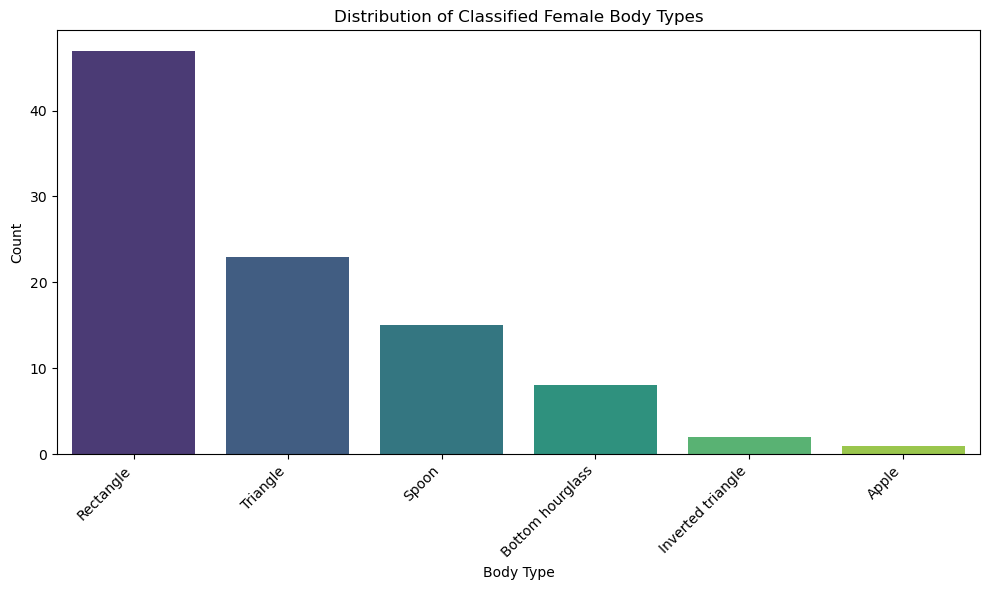

In [20]:
# This is a good way to see the total counts of each classified body type
def plot_body_type_distribution(data_frame):
    """
    Plots a bar chart showing the count of each body type.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(x='body_type', data=merged_df, order=merged_df['body_type'].value_counts().index, palette='viridis')
    plt.title('Distribution of Classified Female Body Types')
    plt.xlabel('Body Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    plot_body_type_distribution(merged_df)

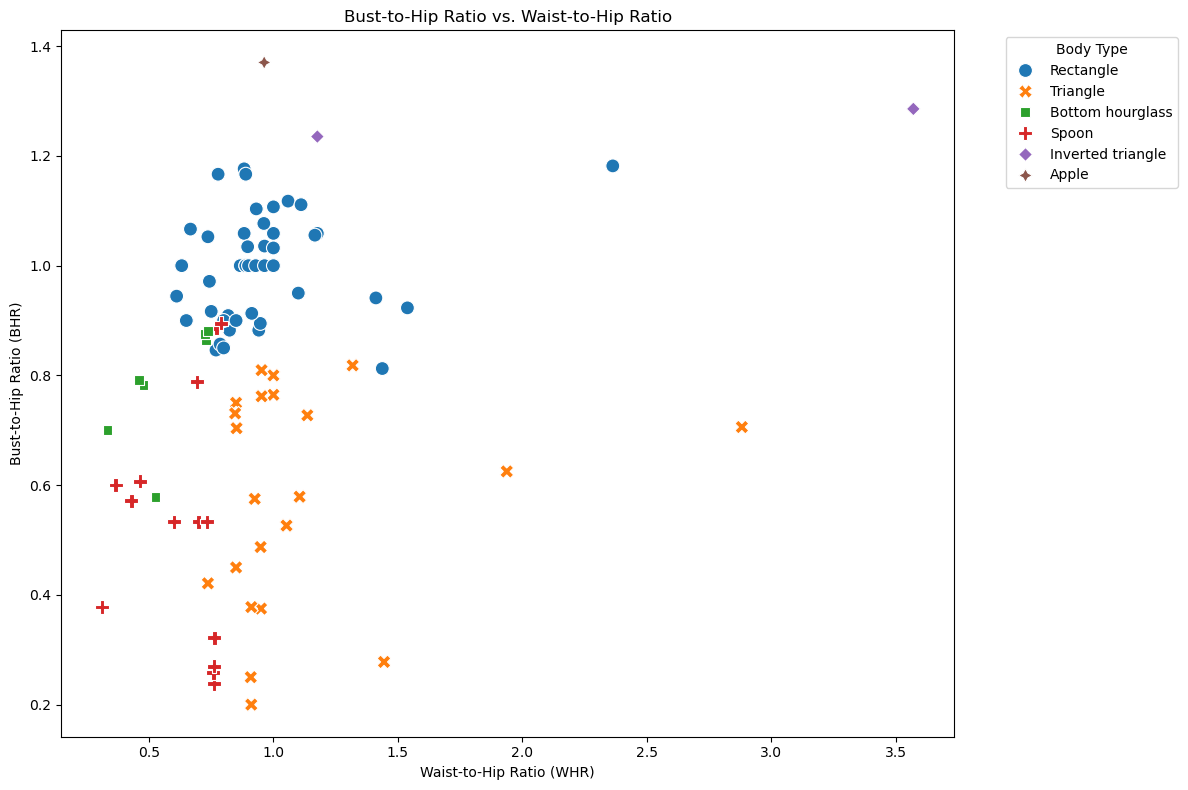

In [21]:
# This visualizes the relationship between the key ratios (WHR vs. BHR) and helps to see how the different body types cluster
def plot_ratio_scatter(data_frame):
    """
    Plots a scatter plot of Bust-to-Hip Ratio (BHR) vs. Waist-to-Hip Ratio (WHR),
    colored by body type.
    """
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='whr', y='bhr', hue='body_type', data=merged_df, style='body_type', s=100, palette='tab10')
    plt.title('Bust-to-Hip Ratio vs. Waist-to-Hip Ratio')
    plt.xlabel('Waist-to-Hip Ratio (WHR)')
    plt.ylabel('Bust-to-Hip Ratio (BHR)')
    plt.legend(title='Body Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    plot_ratio_scatter(merged_df)

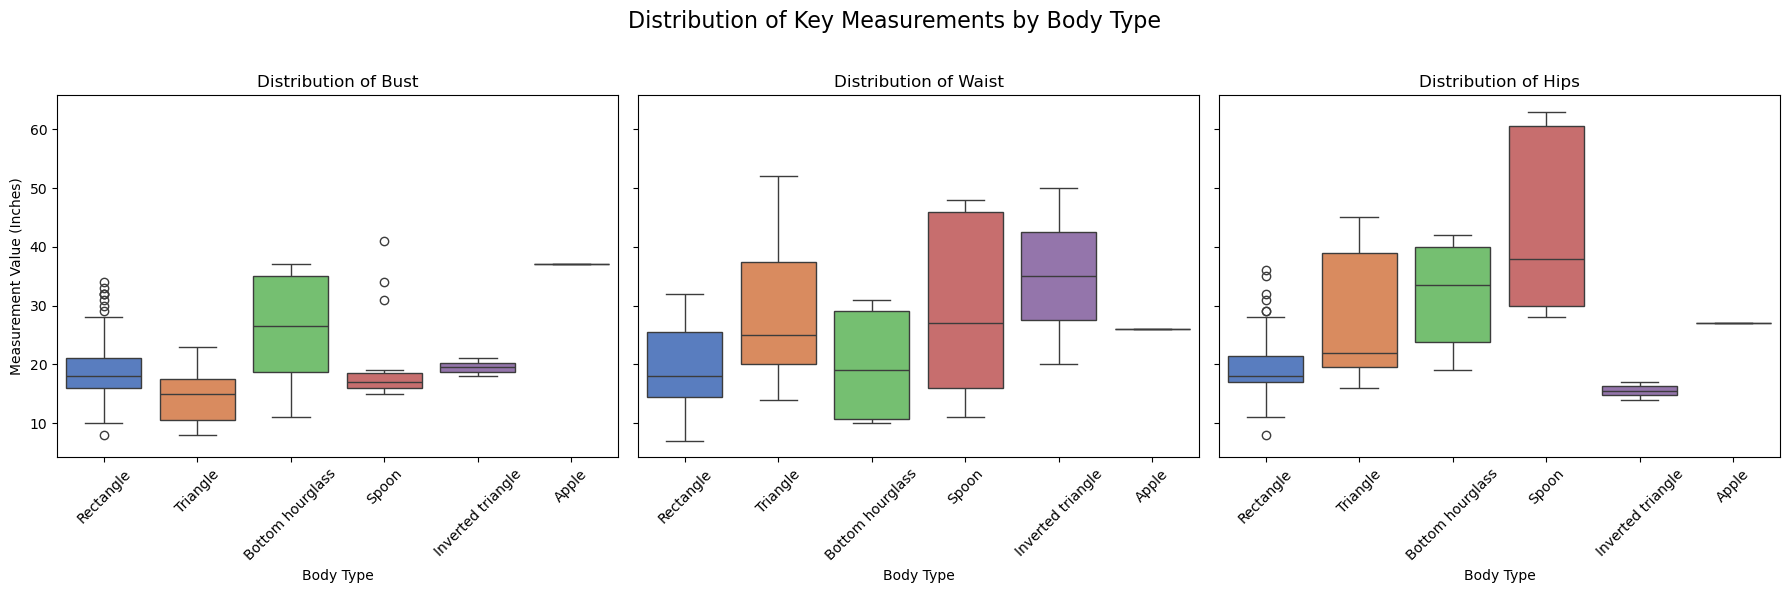

In [22]:
def plot_measurements_by_body_type(data_frame):
    """
    Plots a box plot for bust, waist, and hips for each body type.
    """
    measurements = ['bust', 'waist', 'hips']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Distribution of Key Measurements by Body Type', fontsize=16)

    for i, measurement in enumerate(measurements):
        sns.boxplot(x='body_type', y=measurement, data=merged_df, palette='muted', ax=axes[i])
        axes[i].set_title(f'Distribution of {measurement.capitalize()}')
        axes[i].set_xlabel('Body Type')
        axes[i].set_ylabel('Measurement Value (Inches)')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

if __name__ == '__main__':
    plot_measurements_by_body_type(merged_df)